In [ ]:
!pip install eTaPR-1.12-py3-none-any.whl

In [1]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import trange
from TaPR_pkg import etapr
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.layers import Concatenate,GRU,LSTM,Dropout,TimeDistributed,Reshape,Input, Conv1D, Lambda, Dense, Flatten,MaxPooling1D, concatenate

Using TensorFlow backend.


## 데이터 전처리

학습 데이터와 테스트 데이터는 CSV로 제공됩니다.
HAI 2.0은 단일 파일이 아니라 여러 파일로 제공되기 때문에 디렉토리 안에 있는 모든 CSV를 읽습니다.

In [2]:
TRAIN_DATASET = sorted([x for x in Path("data/HAI_2.0/training/").glob("*.csv")])
TRAIN_DATASET

[WindowsPath('data/HAI_2.0/training/train1.csv'),
 WindowsPath('data/HAI_2.0/training/train2.csv'),
 WindowsPath('data/HAI_2.0/training/train3.csv')]

In [3]:
VALIDATION_DATASET = sorted([x for x in Path("data/HAI_2.0/validation/").glob("*.csv")])
VALIDATION_DATASET

[WindowsPath('data/HAI_2.0/validation/validation.csv')]

In [4]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    len_train=[]
    for x in targets:
        len_train.append(dataframe_from_csv(x).shape[0])
    return pd.concat([dataframe_from_csv(x) for x in targets]),len_train

In [5]:
TRAIN_DF_RAW,len_Train = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,2020-08-10 10:59:56,387.27219,12,10,66.72057,-0.9331,-1.84479,781.87915,28.02389,880.0,...,944.84705,0.0,1.32843,15.17817,35.14710,11.79657,316.89453,296.54950,32.0000,6.6026
478797,2020-08-10 10:59:57,387.52774,12,10,66.72057,-0.9996,-1.84479,787.65070,28.02385,840.0,...,940.49835,0.0,1.32843,15.17344,35.13183,11.79657,315.59247,296.15161,32.0000,6.3894
478798,2020-08-10 10:59:58,387.47665,12,10,66.72057,-1.2560,-1.84479,788.50256,28.03085,792.0,...,935.71472,0.0,1.32919,15.16443,35.13183,11.79657,313.92865,293.40277,32.0000,6.2584
478799,2020-08-10 10:59:59,387.73221,12,10,66.72057,-1.4912,-1.84479,785.80316,28.02649,752.0,...,944.84705,0.0,1.32843,15.09001,35.14710,11.79657,315.61054,302.58972,32.0000,6.4150


In [6]:
len_Train

[216001, 226801, 478801]

In [7]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

In [8]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [9]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [10]:
TRAIN_np=TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].values

In [11]:
TRAIN_DF_norm = normalize(
    TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()


In [12]:
TRAIN_np_norm=TRAIN_DF_norm.values

In [13]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [14]:
boundary_check(TRAIN_np)

(True, True, False)

In [15]:
boundary_check(TRAIN_np_norm)

(False, False, False)

In [16]:
TRAIN_np_norm.shape

(921603, 79)

In [17]:
VALIDATION_DF_RAW,len_Val = dataframe_from_csvs(VALIDATION_DATASET)

In [18]:
VALIDATION_DF_RAW["time"]

0        2020-07-07 15:00:00
1        2020-07-07 15:00:01
2        2020-07-07 15:00:02
3        2020-07-07 15:00:03
4        2020-07-07 15:00:04
                ...         
43196    2020-07-08 02:59:56
43197    2020-07-08 02:59:57
43198    2020-07-08 02:59:58
43199    2020-07-08 02:59:59
43200    2020-07-08 03:00:00
Name: time, Length: 43201, dtype: object

In [19]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [20]:
VALIDATION_np_norm=VALIDATION_DF.values

In [21]:
boundary_check(VALIDATION_np_norm)

(True, True, False)

# DATA preprocessing End

DATA_Matrics

In [22]:
import numpy as np
import pandas as pd
import os

In [23]:
raw_data = TRAIN_np_norm
series_number =raw_data.shape[1]
series_length = raw_data.shape[0]

window=30
gap=1
signature_matrices_number = int(series_length)

print("series_number is",series_number)
print("series_length is", series_length)
print("signature_matrices_number is", signature_matrices_number)


series_number is 79
series_length is 921603
signature_matrices_number is 921603


In [29]:
import random as rnd
def signature_matrices_generation(raw_data,series_number,series_length,signature_matrices_number, win):
    """
        Generation signature matrices according win_size and gap_time, the size of raw_data is n * T, n is the number of
        time series, T is the length of time series.
        To represent the inter-correlations between different pairs of time series in a multivariate time series segment
        from t − w to t, we construct an n × n signature matrix Mt based upon the pairwise inner-product of two time series
        within this segment.
        :param win: the length of the time series segment
        :return: the signature matrices
    """
    idxs=[]
    if win == 0:
        print("The size of win cannot be 0")
    signature_matrices = []
    print("winsize : ",win , " raw data size : ",raw_data.shape)
    for t in range(60,int(raw_data.shape[0])):
        temp=[]
        for j in win:
            raw_data_t = raw_data[t  - j : t, :]
            temp.append(np.dot(raw_data_t.T, raw_data_t) / j)
        signature_matrices.append(np.asarray(temp))
    return signature_matrices

   

In [30]:
train_matrix=[]
skip=0
for i in len_Train:
    train_matrix.append(signature_matrices_generation(TRAIN_np_norm[skip:i],
                                                      series_number,series_length,
                                                      signature_matrices_number,
                                                         [10,30,60]))
    skip=skip+i
train_matrix=np.asarray(train_matrix)

winsize :  [10, 30, 60]  raw data size :  (216001, 79)
winsize :  [10, 30, 60]  raw data size :  (10800, 79)
winsize :  [10, 30, 60]  raw data size :  (35999, 79)


C:\Users\sclab\anaconda3\envs\dacon_2\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [30]:
len_Train

[216001, 226801, 478801]

In [38]:
train_matrix[2][-1].shape

(3, 79, 79)

In [52]:
train_matrix[2].shape

(17999, 3, 79, 79)

In [ ]:
train_matrix_60[1].shape

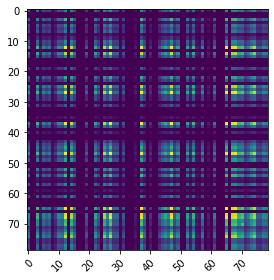

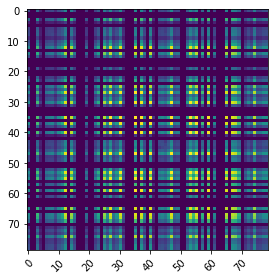

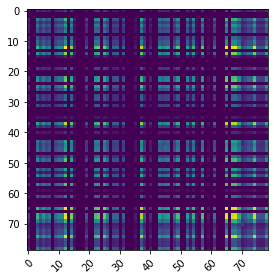

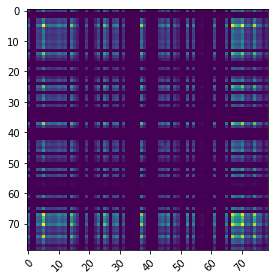

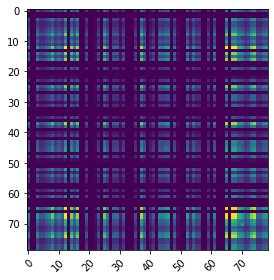

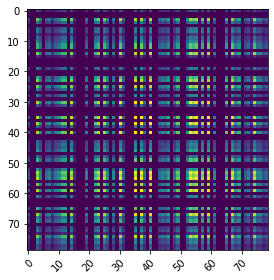

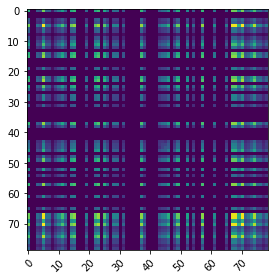

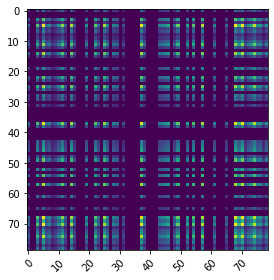

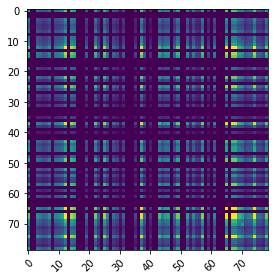

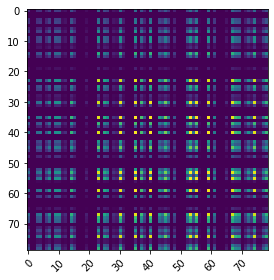

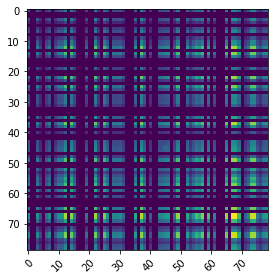

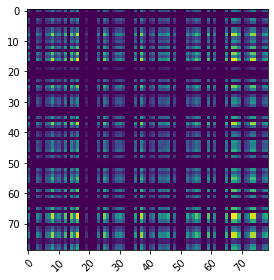

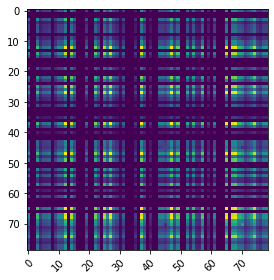

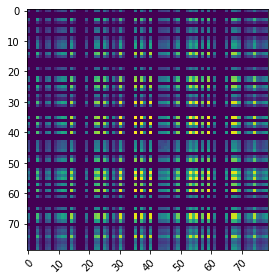

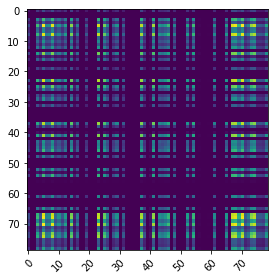

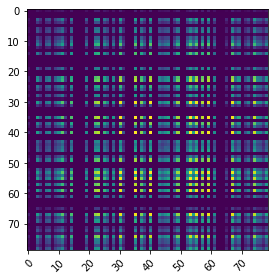

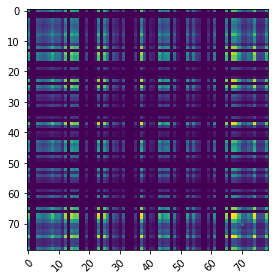

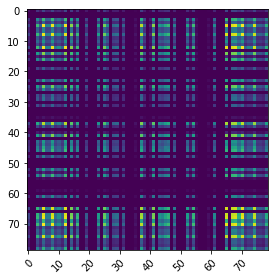

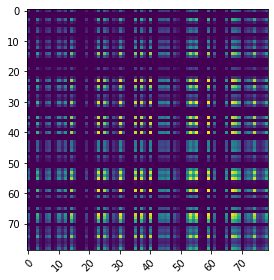

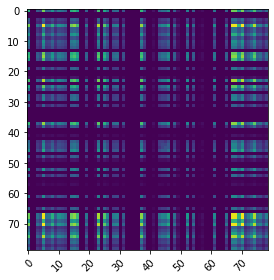

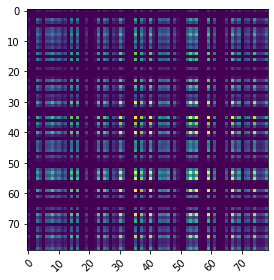

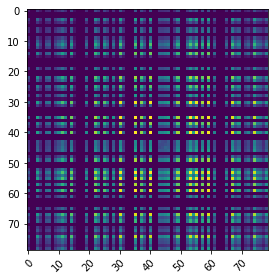

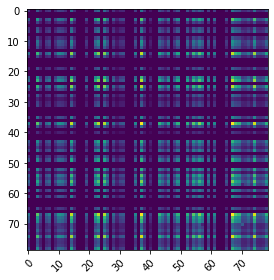

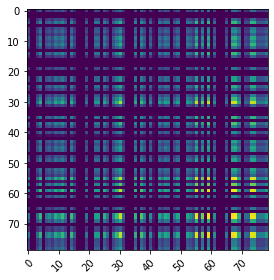

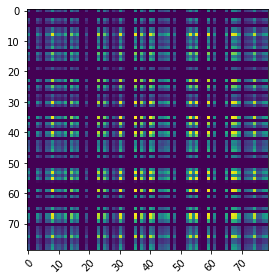

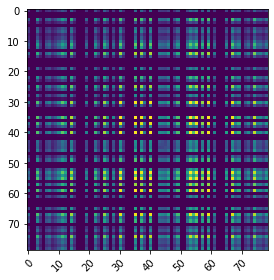

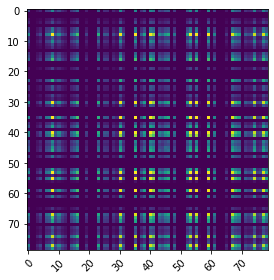

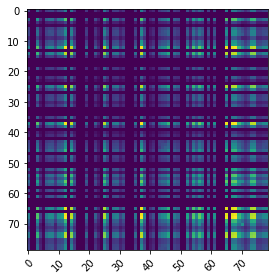

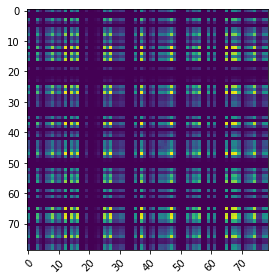

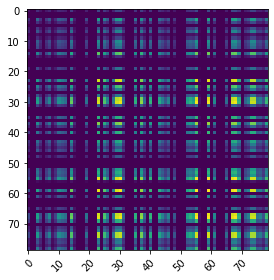

In [39]:
import random as rnd
for i in range(30):
    fig, ax = plt.subplots()
    im = ax.imshow(train_matrix[0][rnd.randrange(0,len(train_matrix[0]))][0])


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.

    fig.tight_layout()
    plt.show()

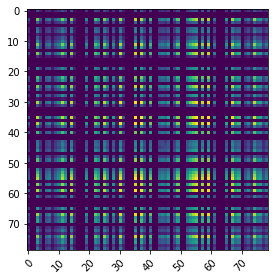

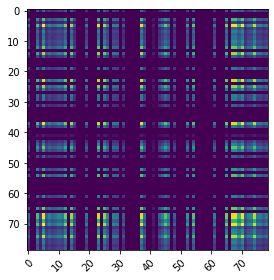

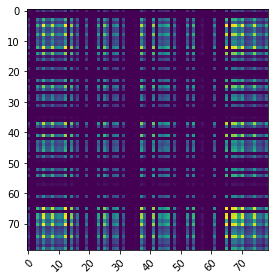

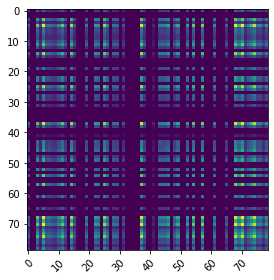

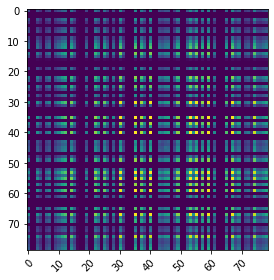

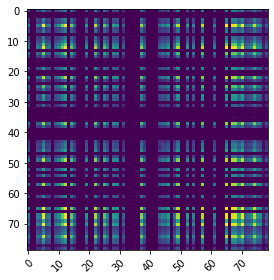

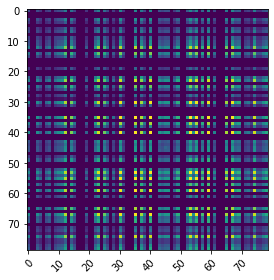

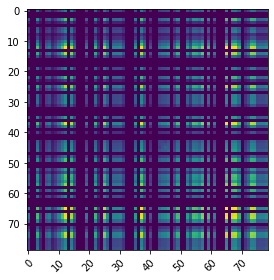

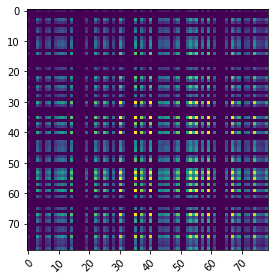

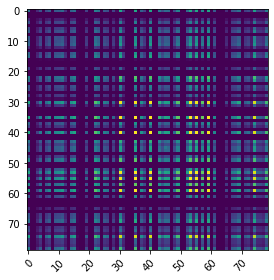

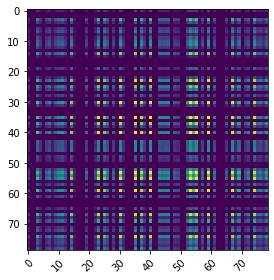

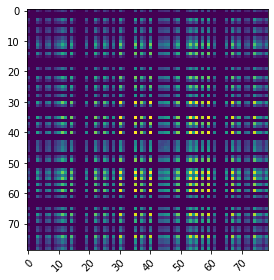

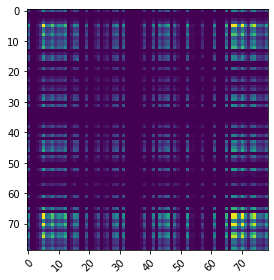

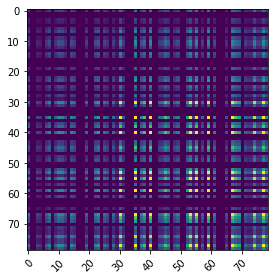

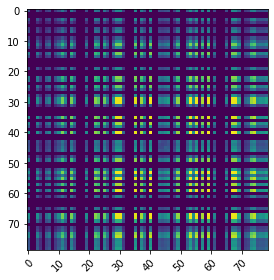

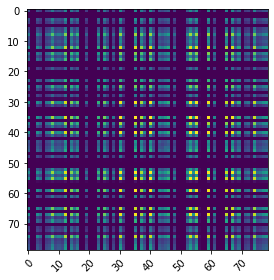

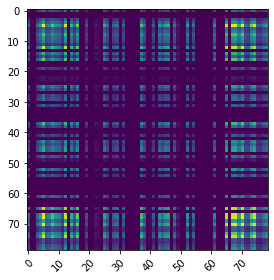

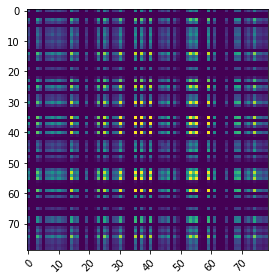

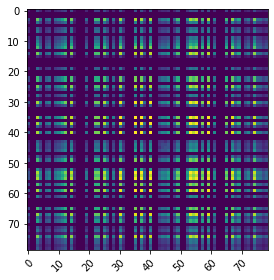

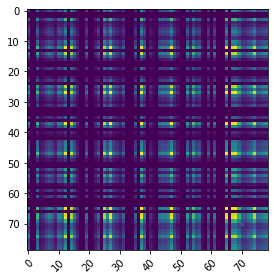

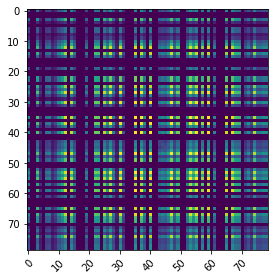

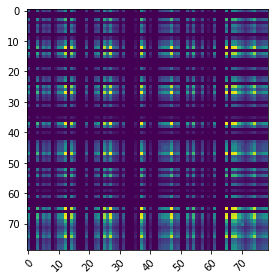

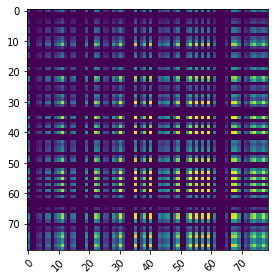

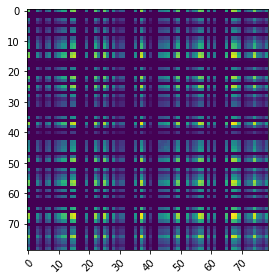

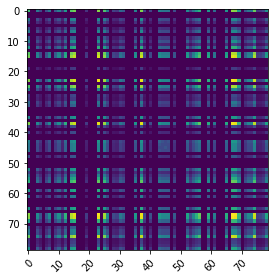

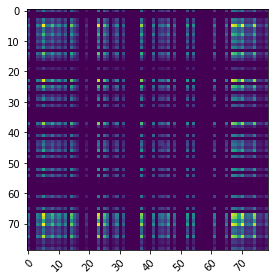

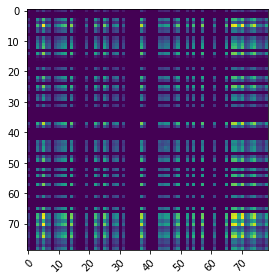

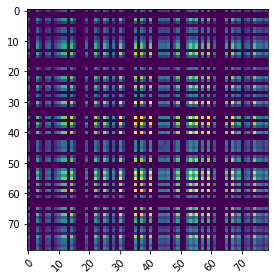

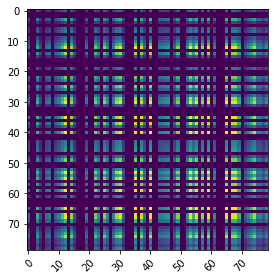

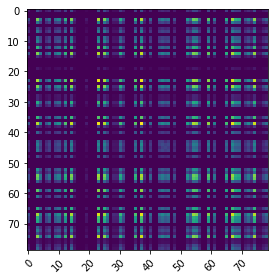

In [40]:
for i in range(30):
    fig, ax = plt.subplots()
    im = ax.imshow(train_matrix[0][rnd.randrange(0,len(train_matrix[0]))][1])


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.

    fig.tight_layout()
    plt.show()

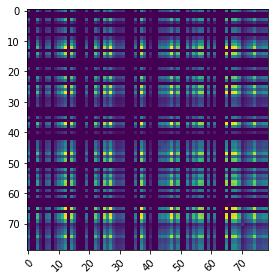

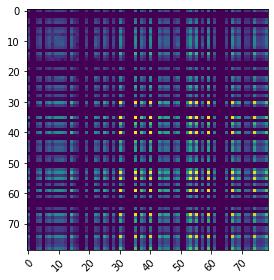

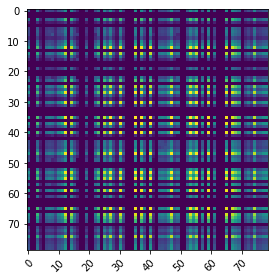

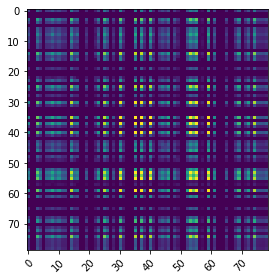

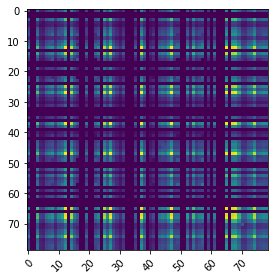

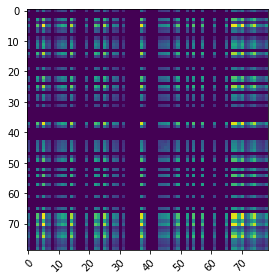

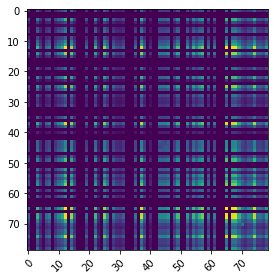

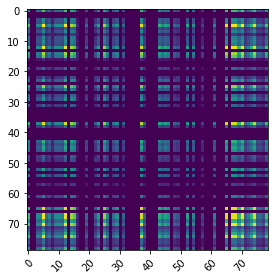

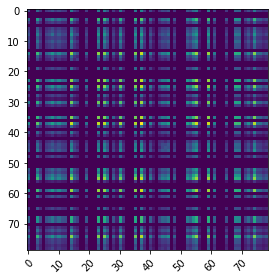

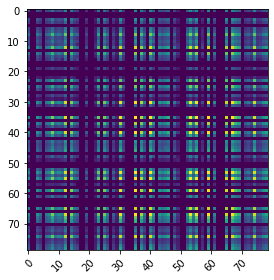

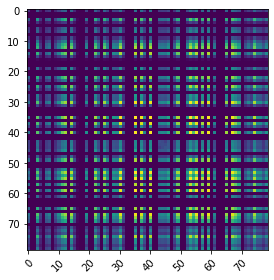

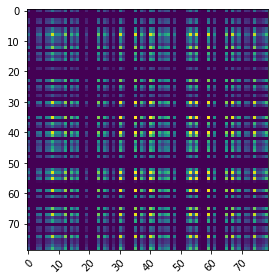

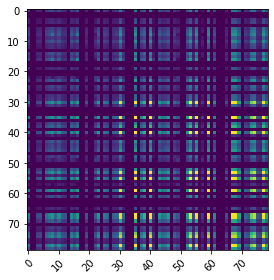

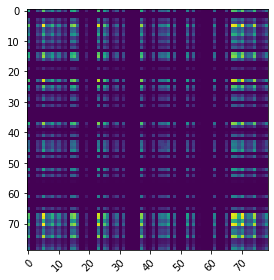

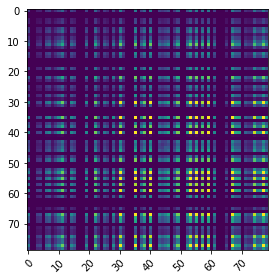

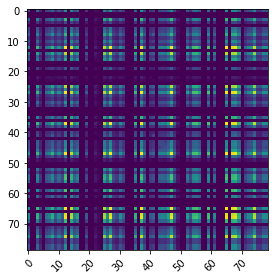

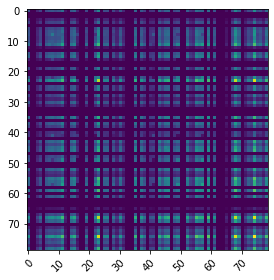

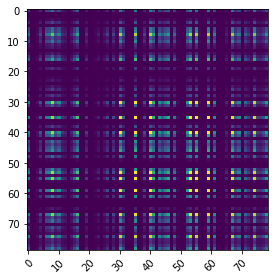

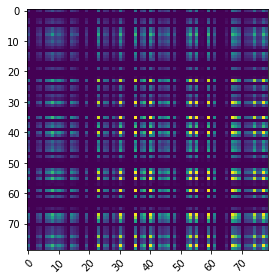

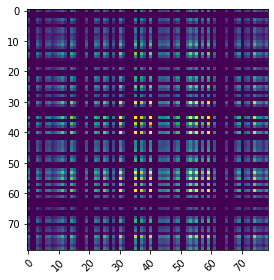

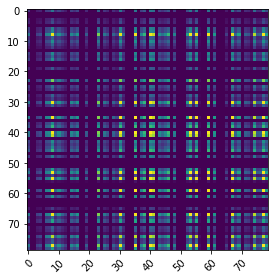

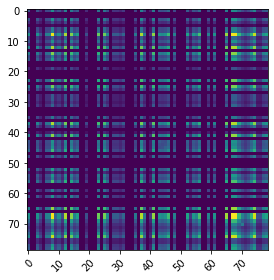

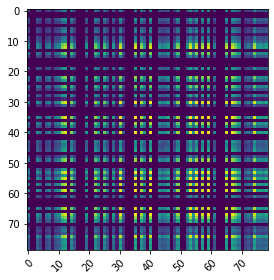

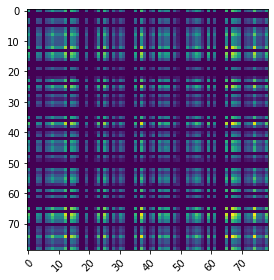

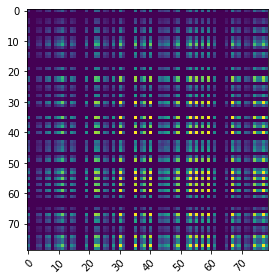

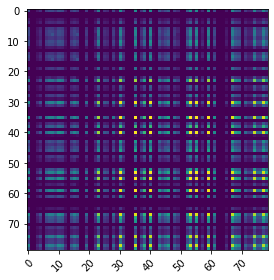

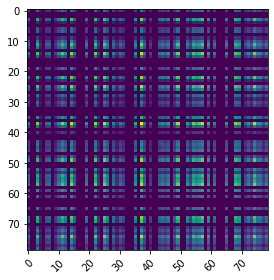

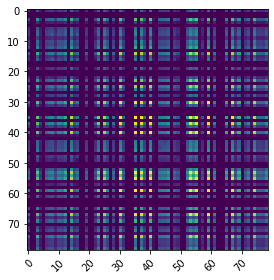

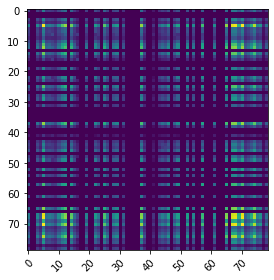

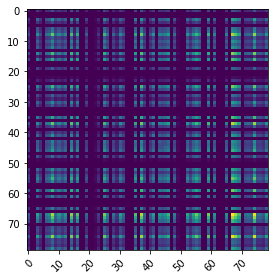

In [41]:
for i in range(30):
    fig, ax = plt.subplots()
    im = ax.imshow(train_matrix[0][rnd.randrange(0,len(train_matrix[0]))][2])


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.

    fig.tight_layout()
    plt.show()

#DATA Train Start

In [68]:
train_matrix[0].shape[1:]

(3, 79, 79)

In [130]:
from keras.layers import Dense, Lambda, dot, Activation, concatenate,Conv2D,UpSampling3D
from keras.layers import Layer


class Attention(Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, hidden_states):
        """
        Many-to-one attention mechanism for Keras.
        @param hidden_states: 3D tensor with shape (batch_size, time_steps, input_dim).
        @return: 2D tensor with shape (batch_size, 128)
        @author: felixhao28.
        """
        hidden_size = int(hidden_states.shape[2])
        # Inside dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W is the trainable weight matrix of attention Luong's multiplicative style score
        score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
        score = dot([score_first_part, h_t], [2, 1], name='attention_score')
        attention_weights = Activation('softmax', name='attention_weight')(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
        pre_activation = concatenate([context_vector, h_t], name='attention_output')
        attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
        return attention_vector

In [142]:
b_input = Input(shape=(train_matrix[0].shape[1:]))
H = Reshape((train_matrix[0].shape[1],train_matrix[0].shape[2],
             train_matrix[0].shape[3], 1))(b_input)
conv1= Conv3D(filters=32,kernel_size=[2,2,2],strides=[2,2,2])(H)
conv2= Conv3D(filters=64,kernel_size=[1,2,2],strides=[2,2,2])(conv1)
conv3= Conv3D(filters=128,kernel_size=[1,2,2],strides=[2,2,2])(conv2)
encoded= Conv3D(filters=256,kernel_size=[1,2,2],strides=[2,2,2])(conv3)


deconv1= Conv3D(filters=256,kernel_size=[1,2,2])(encoded)
deconv1 = UpSampling3D((2, 2,2))(deconv1)
deconv2= Conv3D(filters=128,kernel_size=[1,2,2])(deconv1)
deconv2 = UpSampling3D((2, 2,2))(deconv2)
deconv3= Conv3D(filters=64,kernel_size=[1,2,2])(deconv2)
deconv3 = UpSampling3D((2, 2,2))(deconv3)
deconv4= Conv3D(filters=32,kernel_size=[2,2,2])(deconv3)
deconv4 = UpSampling3D((2, 2,2))(deconv4)
deconv5= Conv3D(filters=1,kernel_size=[2,2,2])(deconv4)
deconv5 = UpSampling3D((2, 2,2))(deconv5)



ValueError: Negative dimension size caused by subtracting 2 from 1 for 'conv3d_116/convolution' (op: 'Conv3D') with input shapes: [?,1,34,34,32], [2,2,2,32,1].

In [141]:
model_cnn_lstm_base = Model(b_input, deconv5)
model_cnn_lstm_base.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse', 'kullback_leibler_divergence','MAPE','MAE'])
model_cnn_lstm_base.summary()


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 3, 79, 79)         0         
_________________________________________________________________
reshape_39 (Reshape)         (None, 3, 79, 79, 1)      0         
_________________________________________________________________
conv3d_99 (Conv3D)           (None, 1, 39, 39, 32)     288       
_________________________________________________________________
conv3d_100 (Conv3D)          (None, 1, 19, 19, 64)     8256      
_________________________________________________________________
conv3d_101 (Conv3D)          (None, 1, 9, 9, 128)      32896     
_________________________________________________________________
conv3d_102 (Conv3D)          (None, 1, 4, 4, 256)      131328    
_________________________________________________________________
conv3d_103 (Conv3D)          (None, 1, 3, 3, 256)      262

In [ ]:
es = EarlyStopping(monitor='loss', restore_best_weights=True, patience=10)
model_cnn_lstm_base.fit(X, Y, validation_data=(X_val, Y_val), epochs=200, batch_size=1024, shuffle=True, callbacks=[es])

In [ ]:
y_val_predict = model_cnn_lstm_base.predict(X_val)

In [ ]:
DIST=np.abs(y_val_predict-Y_val)

In [ ]:
DIST.shape

In [ ]:
CHECK_ATT=VALIDATION_DF_RAW["attack"]

In [ ]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

In [ ]:
ANOMALY_SCORE = np.max(DIST,axis=1)

In [ ]:
ANOMALY_SCORE

In [ ]:
blank_for_NAN=np.zeros(window_size)
ANOMALY_SCORE_for_graph=np.concatenate((blank_for_NAN,ANOMALY_SCORE),axis=0)


inference 함수는 데이터를 순차적으로 보면서 모델이 예측한 값과 실제 값의 차를 구해서 기록합니다.

In [ ]:
THRESHOLD = 1
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

주황색 선은 공격 위치를 나타내고, 파란색 선은 (평균) 오차의 크기를 나타냅니다.
전반적으로 공격 위치에서 큰 오차를 보이고 있습니다.

임의의 threshold(빨간색 선)가 넘어갈 경우 공격으로 간주합니다.
공격은 1로 정상은 0으로 표기합니다.

In [ ]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

위의 그래프를 보면 대략 0.04를 기준으로 설정할 수 있을 것으로 보입니다.
여러 번의 실험을 통해 정밀하게 임계치를 선택하면 더 좋은 결과를 얻을 수 있을 것으로 예상합니다.

In [ ]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

In [ ]:
list(LABELS).count(1)

정답지(ATTACK_LABELS)도 동일하게 추출합니다.
검증 데이터셋에 공격 여부를 나타내는 필드에는 정상을 0으로 공격을 1로 표기하고 있습니다.
위에 정의한 put_labels 함수를 이용해서 0.5를 기준으로 같은 방식으로 TaPR을 위한 label을 붙여줍니다.

In [ ]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

In [ ]:
check_graph(LABELS, ATTACK_LABELS, piece=2, THRESHOLD=THRESHOLD)

In [ ]:
blank_for_NAN=np.zeros(window_size)
Final_Labels=np.concatenate((blank_for_NAN,LABELS),axis=0)


## 평가

평가는 TaPR을 사용합니다.
정답(ATTACK_LABELS)과 모델의 결과(FINAL_LABELS)의 길이가 같은지 확인합니다.

In [ ]:
ATTACK_LABELS.shape[0] == Final_Labels.shape[0]

TaPR 점수를 받습니다.

In [ ]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=Final_Labels)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")